For static replication of any constant maturity swap (CMS) payoff $g(F)$, where $F$ is the swap rate, we use the following formula:

$$\begin{aligned}
      V_0 &= D(0,T) g(F) + h'(F)[V^{pay}(F)-V^{rec}(F)] \\
      &\;\;\;\;\;\;\;\;\;\;+ \int_0^F h''(K) V^{rec}(K) dK +
      \int_F^\infty h''(K) V^{pay}(K) dK
\end{aligned}$$

where

  \begin{equation*}
    \begin{split}
      h(K) &= \frac{g(K)}{\text{IRR}(K)} \\
      h'(K) &= \frac{\text{IRR}(K)g'(K) - g(K)\text{IRR}'(K)}{\text{IRR}(K)^2} \\
      h''(K) &= \frac{\text{IRR}(K)g''(K)-\text{IRR}''(K)g(K) -2\cdot\text{IRR}'(K)g'(K)}{\text{IRR}(K)^2} \\
      &\;\;\;\;\;\;\;\;\;\;+
      \frac{2\cdot\text{IRR}'(K)^2g(K)}{\text{IRR}(K)^3}.
    \end{split}
  \end{equation*}
  
For CMS rate payoff, the payoff function can be defined simply as $g(F)=F$, and the static replication formula simplifies into:

  \begin{equation*}
    \begin{split}
      D(0,T) F + \int_0^F h''(K) V^{rec}(K) dK + \int_F^\infty h''(K) V^{pay}(K) dK
    \end{split}
  \end{equation*}

Let $m$ denote the payment frequency ($m=2$ for semi-annual payment frequency), and let $N = T_N-T_n$ denote the tenor of the swap (number of years), the partial derivatives on the IRR function $\text{IRR}(S)$ given by:
\begin{equation*}
\begin{split}
\text{IRR}(K)&=\sum_{i=1}^{N\times m}\frac{1}{(1+\frac{K}{m})^i}=\frac{1}{K}\left[1-\frac{1}{\left(1+\frac{K}{m}\right)^{N\times m}}\right]\\
\text{IRR}'(K)&=-\frac{1}{K}\text{IRR}(K)
+\frac{1}{m\times K}\frac{N\times m}{\left(1+\frac{K}{m}\right)^{N\times m+1}} \\
\text{IRR}''(K)&=-\frac{2}{K}\text{IRR}'(K)
-\frac{1}{m^2\times K}\frac{N\times m\cdot (N\times m+1)}{\left(1+\frac{K}{m}\right)^{N\times m+2}} \\
\end{split}
\end{equation*}

These results will need to be generalised to handle the case for $m=2$ to be consistent with the semi-annual payment frequency swap market data provided.

---
For CMS rate payment, since $g(F)=F$, we have the derivatives:

\begin{equation*}
\begin{split}
g(K) &= K \\
g'(K) &= 1 \\
g''(K) &= 0
\end{split}
\end{equation*}

# Question 1
## Imports and data wrangling

OIS is in semiannual df. need to also include for quarterly period

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import brentq
from scipy.integrate import quad
from scipy.stats import norm
from scipy.interpolate import interp1d

ois = pd.read_csv('./data/ois.csv')     # load discounting curve
fsr = pd.read_csv('./data/sabr_params.csv')     # load discounting curve
irs = pd.read_csv('./data/irs.csv')             # load par swap rates
# get df for quarterly payments using zero rates
new_expiry = np.arange(0.25, ois["years"].max() + 0.25, 0.25)
ois = ois.set_index("years").reindex(new_expiry)
ois["f"] = ois["f"].bfill() 
ois = ois.ffill()
ois.reset_index(inplace=True)
ois.rename(columns={"index": "years"}, inplace=True)
ois["df"] = ois.apply(lambda row: 1 / ((1 + row['f'] / 360) ** (90)), axis=1)
ois["df_cumprod"] = ois["df"].cumprod()
ois.tail(10)

,years,Tenor,Product,Rate,f,cumsum_df,df,df_cumprod
110,27.75,20y,OIS,0.00525,0.006028,26.182081,0.998494,0.858997
111,28.00,20y,OIS,0.00525,0.006028,27.039784,0.998494,0.857703
112,28.25,20y,OIS,0.00525,0.006028,27.039784,0.998494,0.856412
113,28.50,20y,OIS,0.00525,0.006028,27.039784,0.998494,0.855122
114,28.75,20y,OIS,0.00525,0.006028,27.039784,0.998494,0.853834
115,29.00,20y,OIS,0.00525,0.006028,27.892332,0.998494,0.852548
116,29.25,20y,OIS,0.00525,0.006028,27.892332,0.998494,0.851264
117,29.50,20y,OIS,0.00525,0.006028,27.892332,0.998494,0.849983
118,29.75,20y,OIS,0.00525,0.006028,27.892332,0.998494,0.848703
119,30.00,30y,OIS,0.00550,0.006028,28.739756,0.998494,0.847424


In [80]:
## IRR funcions
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative
# Payoff functions
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative
    
def black76_pay(F, K, expiry, tenor, sigma):
    """
    Return value of payer swaption via Black Normal model only
    parameters
        F: forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = F * norm.cdf(d_1) - K * norm.cdf(d_2)
    return black_option
    
def black76_rec(F, K, expiry, tenor, sigma):
    """
    Return value of receiver swaption via Black Normal model Only
    parameters
        F: Forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = K * norm.cdf(-d_2) - F * norm.cdf(-d_1)
    return black_option

def SABR(F, K, T, alpha, rho, nu, beta=0.9):
    """
    Use SABR model to return sigma, set beta to be 0.9
    """
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

# Carr-Madan Breeden-Litzenberger model free functions
def rec_integrand(F, K, expiry, tenor, alpha, rho, nu, m):
    """
    Return value of receiver integrand per CMS rate payoff. 
    formula: 2nd derivative h * V_rec(per SABR valuation) 
    parameters:
        m: payment freq per year, e.g. 2 is semi-annual
        F: par swap rate
        K: strike of CMS
        expiry: years to expiry of swaption
        tenor: tenor of underlying swap
        alpha: SABR param
        rho: SABR param
        nu: SABR param
    """
    sigma_sabr = SABR(F, K, expiry, alpha, rho, nu, beta=0.9)
    sabr_pricing = black76_rec(F, K, expiry, tenor, sigma_sabr)
    return h_2(K, m, tenor) * sabr_pricing

def pay_integrand(F, K, expiry, tenor, alpha, rho, nu, m):
    """
    Return value of receiver integrand per CMS rate payoff. 
    formula: 2nd derivative h * V_rec(per SABR valuation) 
    parameters:
        m: payment freq per year, e.g. 2 is semi-annual
        F: par swap rate
        K: strike of CMS
        expiry: years to expiry
        tenor: tenor of underlying swap
        alpha: SABR param
        rho: SABR param
        nu: SABR param
    """
    sigma_sabr = SABR(F, K, expiry, alpha, rho, nu, beta=0.9)
    sabr_pricing = black76_pay(F, K, expiry, tenor, sigma_sabr)
    return h_2(K, m, tenor) * sabr_pricing

def v_0(F, expiry, tenor, alpha, rho, nu, m):
    """
    Return forward CMS single coupon payoff based of static replication discounted to today's price. Uses SABR model
    parameters:
        F: par swap rate for given tenor
        expiry: swaption time to expiry
        tenor: underlying swap tenor
        alpha, rho, nu: SABR pricing model params
        m: underlying swap payment frequency per year
    """
    df_expiry = ois.loc[ois.years == expiry]['df'].values[0]
    int_1 = IRR_0(F, m, tenor) * quad(lambda x: rec_integrand(F, x, expiry, tenor, alpha, rho, nu, m), 0.0, F)[0]
    int_2 = IRR_0(F, m, tenor) * quad(lambda x: pay_integrand(F, x, expiry, tenor, alpha, rho, nu, m), F, 0.1)[0]

    return df_expiry * F + int_1 + int_2

# function to compute pv of a series of cms payouts
def forward_cms_coupon(maturity, tenor, m):
    """
    Return PV of receiver leg for CMS as a series of periodic payments. 
    parameters:
        maturity: CMS maturity or swap tenor 
        tenor: tenor of CMS payments to be made
        m: frequency of payments per year
        par_swap_0: first swap rate at t=0 to be paid out in next payment date
    """
    # Data preparation
    df_fwd_irs = fsr.loc[fsr.Tenor == maturity].copy()
    new_expiry = np.arange(0, tenor, 1/m)
    ls_v0 = []
    df_tmp = pd.DataFrame({"Expiry": new_expiry, 
                            "Tenor" : maturity})
    
    # interpolate sabr params
    for col in ["alpha", "rho", "nu"]:
        interp_func = interp1d(df_fwd_irs["Expiry"], 
                            df_fwd_irs[col], 
                            kind="linear", 
                            fill_value="extrapolate")
        df_tmp[col] = interp_func(new_expiry)
    # add par IRS  then interpolate par swap rates
    par_swap_0 = irs.loc[irs.years==maturity,'Rate'].values[0]        # from part 1
    df_fwd_irs.loc[0] = {"Expiry": 0, "f_irs": par_swap_0} 
    df_fwd_irs.sort_values(by="Expiry", inplace=True)
    interp_func = interp1d(df_fwd_irs["Expiry"], 
                        df_fwd_irs['f_irs'], 
                        kind="linear", 
                        fill_value="extrapolate")
    df_tmp['f_irs'] = interp_func(new_expiry)

    # iterate through fixing dates
    for expiry in new_expiry:
        if expiry == 0:
            coupon = df_tmp.iloc[0]['f_irs']
            # print(f"{expiry}: {coupon}")
            ls_v0.append(coupon)       # first payment is fixed at par swap for first period
            continue

        F = df_tmp.loc[df_tmp.Expiry == expiry].f_irs.values[0]
        alpha = df_tmp.loc[df_tmp.Expiry == expiry].alpha.values[0]
        rho = df_tmp.loc[df_tmp.Expiry == expiry].rho.values[0]
        nu = df_tmp.loc[df_tmp.Expiry == expiry].nu.values[0]

        coupon =  v_0(F, expiry, maturity, alpha, rho, nu, m)
        # print(f"{expiry}: {coupon}")
        ls_v0.append(coupon)

    return np.sum(np.array(ls_v0)) / m, ls_v0



### CMS10y for 5 years

In [81]:
res, _ = forward_cms_coupon(10, 5, 2)
f"PV of a leg receiving CMS10y semi-annually over the next 5 years {res:.5f}"

'PV of a leg receiving CMS10y semi-annually over the next 5 years 0.20772'

### CMS2y for 10 years

In [82]:
res, _ = forward_cms_coupon(2, 10, 4)
f"PV of a leg receiving CMS2y semi-annually over the next 10 years {res}"

'PV of a leg receiving CMS2y semi-annually over the next 10 years 0.3954398264641491'

# Question 2
## Compare swaps

In [ ]:
df_irs = fsr.pivot(index='Expiry',
                                columns='Tenor', 
                                values='f_irs')

ls_expiries = df_irs.index
ls_maturities = df_irs.columns

df_cms =  df_irs.copy()
dict_cms = {}

for maturity in ls_maturities:
    for expiry in ls_expiries:
        # df_cms.at[expiry,maturity] = dict_cms[maturity][int(expiry*.5)]
        F = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['f_irs'].values[0]
        alpha = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['alpha'].values[0]
        rho = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['rho'].values[0]
        nu = fsr.loc[(fsr.Expiry==expiry) & (fsr.Tenor==maturity)]['nu'].values[0]
        m = 2       # forward libor is in semi-annual payments, assume the same for CMS

        df_cms.at[expiry, maturity] = v_0(F, expiry, maturity, alpha, rho, nu, m)
        # print(expiry, maturity, v_0(F, expiry, maturity, alpha, rho, nu, m))
      

In [107]:
df_cms

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.032003,0.033422,0.034260,0.035526,0.038943
5,0.040065,0.041332,0.041688,0.043021,0.046983
10,0.043529,0.045339,0.047169,0.050451,0.061704


In [108]:
df_irs

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.031922,0.033217,0.033982,0.035238,0.038419
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042190,0.043116,0.044097,0.046249,0.053458


In [123]:
df_display = (df_cms / df_irs - 1) * 100
df_display.map(lambda x: f"{x:.1f}%")

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.3%,0.6%,0.8%,0.8%,1.4%
5,2.0%,3.1%,4.0%,4.7%,7.7%
10,3.2%,5.2%,7.0%,9.1%,15.4%


the cms rates are greater than forward swap rates

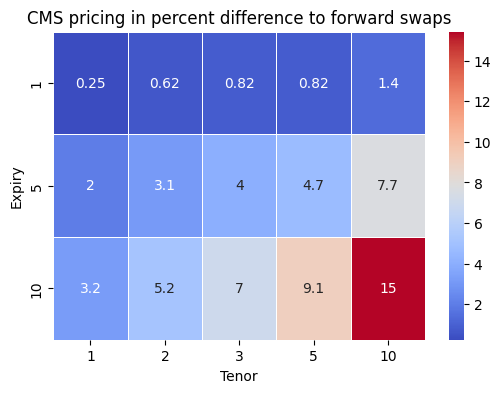

In [ ]:
import seaborn as sns
# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_display, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("CMS pricing in percent difference to forward swaps")
plt.show()

The greatest difference is in bottom right and left. This is where CMS expiry and maturity is the greatest. Further expiries and tenors have a higher premium.